In [ ]:
!pip install --upgrade dowhy>=0.11.0

!pip install numpy==1.25.0

!pip install scikit-learn==1.3.0


In [ ]:
# pip install autogluon
!pip install autogluon==1.1.0

In [ ]:
import dowhy
print(dowhy.__version__)

0.12


In [ ]:
from dowhy import gcm
from dowhy.gcm import StructuralCausalModel

In [ ]:
# Causal Analysis Toolkit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import seaborn as sns
from IPython.display import display
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- DoWhy Import ---
try:
    import dowhy
    from dowhy import gcm
    from dowhy.gcm import (
        StructuralCausalModel,
        arrow_strength,
        intrinsic_causal_influence,
        attribute_anomalies,
        distribution_change
    )
    from dowhy.gcm.auto import assign_causal_mechanisms, AssignmentQuality
    print("✓ DoWhy and GCM modules imported successfully.")
except ImportError as e:
    print(f"Import Error: {e}\nPlease install dowhy>=0.11.0 and ensure Graphviz is available.")
    raise

class CausalAnalysis:
    def __init__(self, df: pd.DataFrame, date_col: str = None):
        self.df = df.copy()
        self.date_col = date_col
        self.scm = None
        self.target_node = None
        self.G = None
        if date_col and date_col in self.df.columns:
            try:
                self.df[date_col] = pd.to_datetime(self.df[date_col])
            except:
                pass
        self.numeric_cols = self.df.select_dtypes(include='number').columns.tolist()

    def summarize_data(self):
        print("=== DATA SUMMARY ===")
        print(f"Rows: {self.df.shape[0]}, Columns: {self.df.shape[1]}")
        if self.numeric_cols:
            stats = self.df[self.numeric_cols].describe().T.round(2)
            display(stats)
            plt.figure(figsize=(8, 6))
            sns.heatmap(self.df[self.numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
            plt.title('Correlation Matrix')
            plt.show()

    def define_causal_graph(self, target_node: str, nodes: list = None, edges: list = None):
        self.target_node = target_node
        all_cols = set(self.df.columns)
        if nodes is None:
            nodes = [c for c in self.numeric_cols if c in all_cols]
        else:
            nodes = [n for n in nodes if n in all_cols]
        if target_node not in nodes:
            nodes.append(target_node)
        self.G = nx.DiGraph()
        self.G.add_nodes_from(nodes)
        if edges:
            valid = [(u, v) for u, v in edges if u in nodes and v in nodes]
            self.G.add_edges_from(valid)
        return self.G

    def fit_scm(self, advanced_mechanisms: bool = True):
        if self.G is None or not self.G.nodes:
            raise ValueError("Define causal graph first.")
        data = self.df[list(self.G.nodes)].reset_index(drop=True)
        self.scm = StructuralCausalModel(self.G)
        if advanced_mechanisms:
            try:
                assignment_summary = assign_causal_mechanisms(
                    self.scm,
                    data,
                    quality=AssignmentQuality.BEST,
                    override_models=True
                )
                print("\n📋 Assigned Causal Mechanisms Summary:")
                print(assignment_summary)
            except Exception as e:
                print(f"Warning: Failed to assign advanced mechanisms: {e}")
        print("Fitting SCM...")
        gcm.fit(self.scm, data)
        print("✅ SCM fitted successfully")
        return self.scm

    def analyze_direct_effects(self):
        if self.scm is None:
            raise ValueError("SCM not fitted. Call fit_scm() first.")
        if self.target_node is None or self.target_node not in self.G.nodes():
            raise ValueError("Target node not defined or not in the graph.")

        raw = arrow_strength(self.scm, target_node=self.target_node)

        filtered_raw = {src: val for (src, tgt), val in raw.items() if src != tgt and tgt == self.target_node}
        total_strength = sum(abs(v) for v in filtered_raw.values()) or 1.0
        percent_strengths = {src: abs(v) / total_strength * 100 for src, v in filtered_raw.items()}

        df_result = pd.DataFrame({
            "Cause": [f"{k[0]} → {k[1]}" if isinstance(k, tuple) else str(k) for k in percent_strengths.keys()],
            "Influence (%)": list(percent_strengths.values())
        }).sort_values("Influence (%)", ascending=False)

        print(f"\nDirect Arrow Strength → {self.target_node}")
        display(df_result)

        fig = px.bar(
            df_result,
            x="Influence (%)",
            y="Cause",
            orientation='h',
            title=f"Direct Arrow Strength → {self.target_node}",
            template='plotly_white'
        )
        fig.update_layout(
            yaxis={'autorange': 'reversed'},
            xaxis_title="Influence (%)",
            yaxis_title=""
        )
        fig.show()

        return percent_strengths

    def analyze_intrinsic_contrib(self, num_samples: int = 500):
        if self.scm is None:
            raise ValueError("SCM not fitted. Call fit_scm() first.")

        raw = intrinsic_causal_influence(self.scm, self.target_node, num_samples_randomization=num_samples)
        raw.pop(self.target_node, None)
        total = sum(abs(x) for x in raw.values()) or 1.0
        pct = {k: abs(v)/total*100 for k, v in raw.items()}

        df_result = pd.DataFrame({
            "Variable": list(pct.keys()),
            "Contribution (%)": list(pct.values())
        }).sort_values("Contribution (%)", ascending=False)

        print(f"\nIntrinsic Causal Contribution → {self.target_node}")
        display(df_result)

        fig = px.bar(
            df_result,
            x="Contribution (%)",
            y="Variable",
            orientation='h',
            title=f"Intrinsic Causal Contribution → {self.target_node}",
            template='plotly_white'
        )
        fig.update_layout(
            yaxis={'autorange': 'reversed'},
            xaxis_title="Contribution (%)",
            yaxis_title=""
        )
        fig.show()

        return pct

    def analyze_anomaly(self, df: pd.DataFrame = None, sample_idx: int = None, sample_date: str = None):
        if self.scm is None:
            raise ValueError("SCM not fitted. Call fit_scm() first.")

        df = df if df is not None else self.df

        if sample_date and self.date_col and self.date_col in df.columns:
            df[self.date_col] = pd.to_datetime(df[self.date_col], errors='coerce')
            samp = df[df[self.date_col] == pd.to_datetime(sample_date)]
            if samp.empty:
                raise ValueError(f"No data found for sample_date = '{sample_date}'. Please check your date format and range.")
            samp = samp.head(1)
        elif sample_idx is not None:
            samp = df.iloc[[sample_idx]]
        else:
            col = df[self.target_node]
            idx = col.idxmax() if abs(col.max()) >= abs(col.min()) else col.idxmin()
            samp = df.loc[[idx]]

        print(f"\nAnomaly sample indices: {samp.index.tolist()}")
        display(samp)

        valid_cols = [c for c in self.G.nodes]
        sample_data = samp[valid_cols]

        if isinstance(sample_data, pd.Series):
            sample_data = sample_data.to_frame().T

        if sample_data.empty:
            raise ValueError("Sample data is empty. Cannot run anomaly attribution on 0 samples.")

        print("\nSample data passed to attribute_anomalies():")
        display(sample_data)

        # Run full attribution including target variable
        result = attribute_anomalies(
          causal_model=self.scm,
          target_node=self.target_node,
          anomaly_samples=sample_data,
        )

        # Exclude the target variable from results
        scores = {
            k: float(v[0]) if isinstance(v, (list, tuple, np.ndarray)) else float(v)
            for k, v in result.items()
            if k != self.target_node
        }

        df_result = pd.DataFrame({
            "Variable": list(scores.keys()),
            "Score": list(scores.values())
        }).sort_values("Score", key=lambda x: abs(x), ascending=False)

        df_result["Score"] = pd.to_numeric(df_result["Score"], errors="coerce")

        print("Anomaly Attribution Scores:")
        display(df_result)

        fig = px.bar(
            df_result,
            x="Score",
            y="Variable",
            orientation='h',
            title='Anomaly Attribution',
            template='plotly_white'
        )
        fig.update_layout(
            yaxis={'autorange': 'reversed'},
            xaxis_title="Attribution Score",
            yaxis_title="",
            bargap=0.3
        )
        fig.show()

        return scores

    def analyze_distribution_change(self, ref: pd.DataFrame, test: pd.DataFrame):
        if self.scm is None:
            raise ValueError("SCM not fitted. Call fit_scm() first.")

        ref_data = ref[list(self.G.nodes)]
        test_data = test[list(self.G.nodes)]

        raw = distribution_change(self.scm, ref_data, test_data, target_node=self.target_node)
        raw.pop(self.target_node, None)

        df_result = pd.DataFrame({
            "Variable": list(raw.keys()),
            "Attribution": list(raw.values())
        }).sort_values("Attribution", key=lambda x: abs(x), ascending=False)

        print(f"\nDistribution Change Attribution → {self.target_node}")
        display(df_result)

        fig = px.bar(
            df_result,
            x="Attribution",
            y="Variable",
            orientation='h',
            title='Distribution Change Attribution',
            template='plotly_white'
        )
        fig.update_layout(
            yaxis={'autorange': 'reversed'},
            xaxis_title="Attribution Score",
            yaxis_title=""
        )
        fig.show()

        return raw


✓ DoWhy and GCM modules imported successfully.


=== DATA SUMMARY ===
Rows: 730, Columns: 8


,count,mean,std,min,25%,50%,75%,max
total_revenue,730.0,3466052.99,2451486.39,32411.59,1590338.01,2899624.49,4842960.71,1.615572e+07
impressions_Facebook,730.0,53889949.42,17265149.62,0.00,41275244.09,52943668.55,65793545.51,1.074242e+08
impressions_TV,730.0,2024198.16,676304.89,0.00,1547034.39,1990912.04,2449330.28,4.264401e+06
clicks_Search,730.0,469246.86,153988.84,0.00,360209.62,472127.51,568615.46,9.129236e+05
spend_Facebook,730.0,161695.54,51825.38,0.00,123730.25,159103.32,197678.33,3.200609e+05
spend_TV,730.0,40584.71,13551.19,0.00,31030.68,39860.88,49199.77,8.474858e+04
spend_Search,730.0,121387.86,39466.52,0.00,93750.06,122022.63,147017.33,2.497623e+05


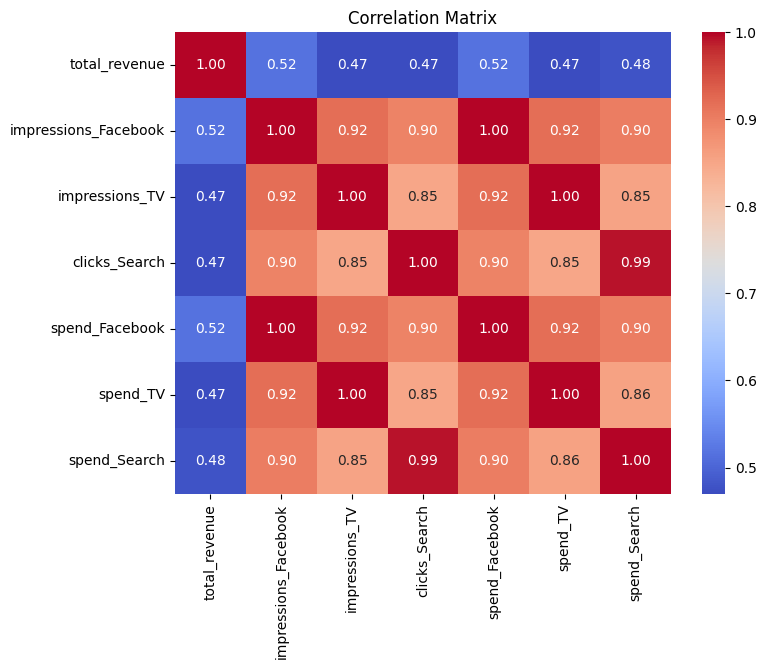


📋 Assigned Causal Mechanisms Summary:
When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the b

Fitting causal mechanism of node spend_Search:  25%|██▌       | 1/4 [00:25<01:16, 25.36s/it]  	Warning: Exception caused NeuralNetFastAI to fail during training... Skipping this model.
		Exception occured in `AgSaveModelCallback` when calling event `after_epoch`:
	unsupported operand type(s) for -: 'NoneType' and 'float'
Fitting causal mechanism of node total_revenue: 100%|██████████| 4/4 [01:21<00:00, 20.29s/it]


✅ SCM fitted successfully


Test permutations of given graph: 100%|██████████| 24/24 [00:00<00:00, 1044.81it/s]


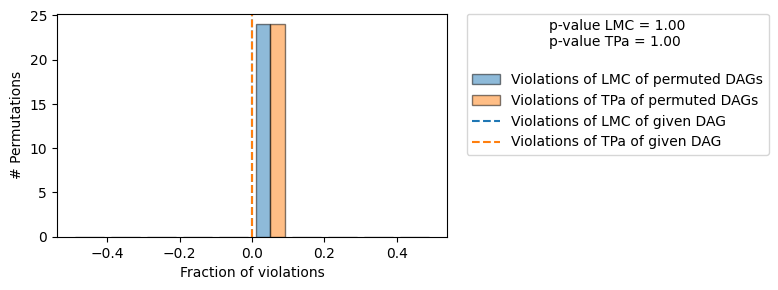

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:

# 1. Load your data
df = pd.read_csv('/content/masters_daily_level_dataset_rev50.csv')

# 2. Initialize the causal analysis
ca = CausalAnalysis(df, date_col='DATE')

# 3. Summarize the data
ca.summarize_data()

# 4. Define the causal graph
target = 'total_revenue'
nodes = ['spend_Facebook', 'spend_Search', 'spend_TV', target]
edges = [
    ('spend_TV', 'spend_Facebook'),
    ('spend_TV', 'spend_Search'),
    ('spend_Facebook', 'spend_Search'),
    ('spend_Facebook', target),
    ('spend_Search', target),
    ('spend_TV', target)

]
ca.define_causal_graph(target, nodes, edges)

# 5. Fit the SCM
ca.fit_scm()

from joblib import parallel_backend
# 6. Evaluate the fitted GCM using threads
with parallel_backend('threading'):
    eval_result = gcm.evaluate_causal_model(
        ca.scm,
        df.reset_index(drop=True),
        compare_mechanism_baselines=True
    )
print(eval_result)


In [ ]:
# 6. Analyze direct effects
ca.analyze_direct_effects()




Direct Arrow Strength → total_revenue


,Cause,Influence (%)
0,spend_Facebook,71.313472
1,spend_Search,21.722231
2,spend_TV,6.964298


{'spend_Facebook': 71.31347169601766,
 'spend_Search': 21.72223068172123,
 'spend_TV': 6.964297622261113}

In [ ]:
# 7. Analyze intrinsic causes
ca.analyze_intrinsic_contrib()



Evaluating set functions...: 100%|██████████| 16/16 [00:42<00:00,  2.68s/it]



Intrinsic Causal Contribution → total_revenue


,Variable,Contribution (%)
0,spend_TV,83.189831
1,spend_Facebook,15.177470
2,spend_Search,1.632699


{'spend_TV': 83.18983071768685,
 'spend_Facebook': 15.177470169506632,
 'spend_Search': 1.6326991128065107}

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np



# Optional: convert date if needed
df['DATE'] = pd.to_datetime(df['DATE'])

# Compute rolling mean and standard deviation
df['rolling_mean'] = df['total_revenue'].rolling(window=7, center=True).mean()
df['rolling_std'] = df['total_revenue'].rolling(window=7, center=True).std()

# Define spikes: e.g., > 2 standard deviations above rolling mean
df['is_spike'] = df['total_revenue'] > (df['rolling_mean'] + 2 * df['rolling_std'])

# Create figure
fig = px.line(
    df,
    x='DATE',
    y='total_revenue',
    title='Total Revenue Over Time',
    hover_data={'DATE': True, 'total_revenue': True, 'is_spike': True}
)

# Add spike markers
spikes = df[df['is_spike']]
fig.add_scatter(
    x=spikes['DATE'],
    y=spikes['total_revenue'],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Spike'
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Revenue',
    legend_title='Legend'
)

fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Assuming df is already defined with DATE and total_revenue columns

# Convert date if needed
if not pd.api.types.is_datetime64_any_dtype(df['DATE']):
    df['DATE'] = pd.to_datetime(df['DATE'])

# Compute rolling metrics
window_size = 7
df['rolling_mean'] = df['total_revenue'].rolling(window=window_size, center=True).mean()
df['rolling_std'] = df['total_revenue'].rolling(window=window_size, center=True).std()

# Define spikes with statistical threshold
std_threshold = 2
df['is_spike'] = df['total_revenue'] > (df['rolling_mean'] + std_threshold * df['rolling_std'])
df['deviation'] = (df['total_revenue'] - df['rolling_mean']) / df['rolling_std']

# Create subplots: main revenue chart and deviation chart
fig = make_subplots(rows=2, cols=1,
                   shared_xaxes=True,
                   vertical_spacing=0.1,
                   row_heights=[0.7, 0.3],
                   subplot_titles=('Total Revenue Over Time', 'Standard Deviation from Mean'))

# Add main revenue line
fig.add_trace(
    go.Scatter(
        x=df['DATE'],
        y=df['total_revenue'],
        mode='lines',
        name='Revenue',
        line=dict(color='#3366CC', width=1.5),
        hovertemplate='<b>Date</b>: %{x}<br><b>Revenue</b>: $%{y:,.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Add rolling mean
fig.add_trace(
    go.Scatter(
        x=df['DATE'],
        y=df['rolling_mean'],
        mode='lines',
        name=f'{window_size}-Day Average',
        line=dict(color='#FF9900', width=2, dash='dash'),
        hovertemplate='<b>Date</b>: %{x}<br><b>Mean</b>: $%{y:,.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Add confidence bands (±2 std dev)
fig.add_trace(
    go.Scatter(
        x=df['DATE'],
        y=df['rolling_mean'] + std_threshold * df['rolling_std'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df['DATE'],
        y=df['rolling_mean'] - std_threshold * df['rolling_std'],
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(200, 200, 200, 0.2)',
        name='±2σ Range',
        hoverinfo='skip'
    ),
    row=1, col=1
)

# Add spike markers
spikes = df[df['is_spike']]
fig.add_trace(
    go.Scatter(
        x=spikes['DATE'],
        y=spikes['total_revenue'],
        mode='markers',
        marker=dict(
            size=10,
            color='red',
            symbol='diamond',
            line=dict(width=2, color='darkred')
        ),
        name='Spikes',
        hovertemplate='<b>Date</b>: %{x}<br><b>Revenue</b>: $%{y:,.2f}<br><b>Deviation</b>: %{text:.2f}σ<extra></extra>',
        text=spikes['deviation']
    ),
    row=1, col=1
)

# Add deviation chart
fig.add_trace(
    go.Bar(
        x=df['DATE'],
        y=df['deviation'],
        marker_color=df['deviation'].apply(
            lambda x: 'rgba(255,0,0,0.7)' if x > std_threshold else
                     ('rgba(0,0,255,0.7)' if x < -std_threshold else 'rgba(100,100,100,0.5)')
        ),
        name='Deviation (σ)',
        hovertemplate='<b>Date</b>: %{x}<br><b>Deviation</b>: %{y:.2f}σ<extra></extra>'
    ),
    row=2, col=1
)

# Add threshold lines on deviation chart
fig.add_shape(
    type="line", line=dict(dash="dash", color="red", width=1),
    x0=df['DATE'].min(), x1=df['DATE'].max(), y0=std_threshold, y1=std_threshold,
    row=2, col=1
)

fig.add_shape(
    type="line", line=dict(dash="dash", color="blue", width=1),
    x0=df['DATE'].min(), x1=df['DATE'].max(), y0=-std_threshold, y1=-std_threshold,
    row=2, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Revenue Performance with Anomaly Detection',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)
    },
    hovermode='closest',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    height=800,
    template='plotly_white',
    margin=dict(l=60, r=40, t=100, b=40)
)

# Update axes
fig.update_xaxes(
    title_text='Date',
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    ),
    row=1, col=1
)

fig.update_yaxes(title_text='Revenue ($)', row=1, col=1)
fig.update_yaxes(title_text='Standard Deviations (σ)', row=2, col=1)

# Show the figure
fig.show()

In [ ]:
# Ensure DATE is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Define time windows
ref_df = df[(df['DATE'] >= '2022-01-01') & (df['DATE'] < '2023-01-01')]  # Jan–Dec 2022
test_df = df[(df['DATE'] >= '2023-01-01') & (df['DATE'] < '2024-01-01')]  # Jan–Dec 2023 or up to available data

# Run Distribution Change Attribution
ca.analyze_distribution_change(ref_df, test_df)




Evaluating set functions...: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]



Distribution Change Attribution → total_revenue


,Variable,Attribution
2,spend_TV,-0.003411
1,spend_Search,0.002188
0,spend_Facebook,-0.000964


Evaluating set functions...: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]



Distribution Change Attribution → total_revenue


,Variable,Attribution
2,spend_TV,-0.003411
1,spend_Search,0.002188
0,spend_Facebook,-0.000964


{'spend_Facebook': -0.0009643868045197278,
 'spend_Search': 0.0021878278281375293,
 'spend_TV': -0.003411268851755331}

In [ ]:
mean_2022 = ref_df['total_revenue'].mean()
mean_2023 = test_df['total_revenue'].mean()
print(f"2022 Mean: {mean_2022:.4f}, 2023 Mean: {mean_2023:.4f}")

2022 Mean: 3457619.1141, 2023 Mean: 3474486.8720


In [ ]:
# 10. Attribute anomalies
ca.analyze_anomaly(df, sample_idx=407)



Anomaly sample indices: [407]


,index,DATE,total_revenue,impressions_Facebook,impressions_TV,clicks_Search,spend_Facebook,spend_TV,spend_Search
407,407,2023-02-12,1.378840e+07,8.922033e+07,2.902931e+06,630886.885447,268051.39578,58239.711872,163031.823464



Sample data passed to attribute_anomalies():


,spend_Facebook,spend_Search,spend_TV,total_revenue
407,268051.39578,163031.823464,58239.711872,1.378840e+07


Evaluating set functions...: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


Anomaly Attribution Scores:


,Variable,Score
0,spend_TV,1.861521
2,spend_Search,1.444825
1,spend_Facebook,0.972768


{'spend_TV': 1.86152068129665,
 'spend_Facebook': 0.9727680231297982,
 'spend_Search': 1.4448253505292379}

In [ ]:
ca.analyze_anomaly(df, sample_date='2022-06-23')


Anomaly sample indices: [173]


,level_0,index,DATE,total_revenue,impressions_Facebook,impressions_TV,clicks_Search,spend_Facebook,spend_TV,spend_Search,rolling_mean,rolling_std,is_spike,deviation
173,173,173,2022-06-23,1.615572e+07,8.041109e+07,3.388993e+06,733541.44555,241111.967912,66666.528209,185241.626085,5.660552e+06,4.759745e+06,True,2.204985



Sample data passed to attribute_anomalies():


,spend_Facebook,spend_Search,spend_TV,total_revenue
173,241111.967912,185241.626085,66666.528209,1.615572e+07


Evaluating set functions...: 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


Anomaly Attribution Scores:


,Variable,Score
0,spend_TV,2.069462
2,spend_Search,0.575129
1,spend_Facebook,0.390347


{'spend_TV': 2.069461904918711,
 'spend_Facebook': 0.39034706785477186,
 'spend_Search': 0.5751294327550951}